In [1]:
%pip install --no-cache-dir ttAugment
%pip install --no-cache-dir building-footprint-segmentation

  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.2
Note: you may need to restart the kernel to use updated packages.


ERROR: Cannot uninstall numpy 1.19.2, RECORD file not found. You might be able to recover from this via: 'pip install --force-reinstall --no-deps numpy==1.19.2'.


In [2]:
import cv2
import torch
import numpy as np

from building_footprint_segmentation.seg.binary.models import DLinkNet34
from building_footprint_segmentation.helpers.normalizer import min_max_image_net
from building_footprint_segmentation.utils.py_network import (
    to_input_image_tensor,
    add_extra_dimension,
    convert_tensor_to_numpy,
    load_parallel_model,
    adjust_model
)
from torch.utils import model_zoo
from tt_augment.augment import generate_seg_augmenters

%matplotlib inline 
from matplotlib import pyplot as plt


C:\Users\Fuzail.Palnak\Anaconda3\envs\bld\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] The specified module could not be found
  warn(f"Failed to load image Python extension: {e}")


In [3]:
def get_model():
    model = DLinkNet34()
    state_dict = model_zoo.load_url(r"https://github.com/fuzailpalnak/building-footprint-segmentation/releases/download/v0.2.3/DlinkNet.zip", progress=True, map_location="cpu")
    state_dict = adjust_model(state_dict["model"])
    model.load_state_dict(state_dict)
    return model

In [4]:
IMG_PTH = r"pth/to/input/image"

TRANSFORMATION_TO_APPLY = [
  {"name": "Mirror", "crop_to_dimension": (128, 128)},
  {"name": "CropScale", "crop_to_dimension": (128, 128)},
]


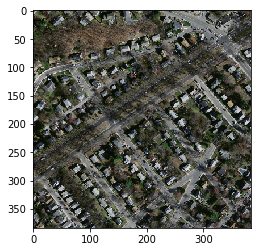

In [5]:
original_image = cv2.imread(IMG_PTH)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
plt.imshow(original_image, interpolation='nearest')
plt.show()

In [6]:
image = min_max_image_net(img=original_image)
image = np.expand_dims(image, 0)

h, w, _ = original_image.shape
number_of_output_channels = 1

tta = generate_seg_augmenters(
            image=image,
            window_size=(256, 256),
            output_dimension=(1, h, w, number_of_output_channels),
            transformation_to_apply=TRANSFORMATION_TO_APPLY,
        )

model = get_model()

C:\Users\Fuzail.Palnak\Anaconda3\envs\bld\lib\site-packages\torch\hub.py:513: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


In [7]:
for iterator, transformation in enumerate(tta):
    for augmented_fragment in transformation.transform_fragment():
        tensor_image = to_input_image_tensor(augmented_fragment).swapaxes(0, 1)

        with torch.no_grad():
            # Perform prediction
            prediction = model(tensor_image)
            prediction = prediction.sigmoid()
            
            prediction_binary = convert_tensor_to_numpy(prediction.swapaxes(-1, 1))
            transformation.restore_fragment(prediction_binary)

tta.merge()

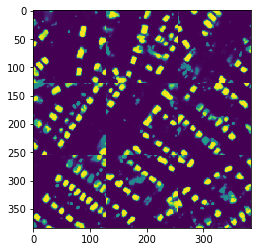

In [8]:
output = tta.tta_output()
plt.imshow(output[0], interpolation='nearest')
plt.show()